### **Phase 1: Player Detection and Initial Analysis** 🏃‍♂️⚽️

1. **YOLOv11 Fine-Tuning for Player Detection** 🎯
   - Adapt YOLOv11 for detecting football players on the field.
   - **Objective**: Ensure robust detection of players, even under challenging scenarios like crowded scenes or varying lighting conditions.

In [ ]:
import torch
print(torch.backends.mps.is_available())
print(torch.cuda.is_available())

False
True


In [10]:
!yolo task=detect mode=train model="/content/drive/MyDrive/FootCVision/utils/yolo11s.pt" data="/content/drive/MyDrive/dataset/data.yaml" epochs=10 imgsz=640 device=0

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/FootCVision/utils/yolo11s.pt, data=/content/drive/MyDrive/dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

1.2 **Inference on Youtube Video** !

In [2]:
!yolo task=detect mode=predict model="/Users/alyazouzou/Desktop/CV_Football/FootCVision2/phase1/runs/detect/train/weights/best.pt" source="/Users/alyazouzou/Desktop/CV_Football/vids/demo.mov" device=mps project="/Users/alyazouzou/Desktop/CV_Football/vids" name="output"

Ultralytics 8.3.57 🚀 Python-3.9.21 torch-2.5.1 MPS (Apple M3)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

video 1/1 (frame 1/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 17 players, 1 referee, 188.4ms
video 1/1 (frame 2/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 17 players, 1 referee, 26.0ms
video 1/1 (frame 3/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 18 players, 1 referee, 14.1ms
video 1/1 (frame 4/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 18 players, 1 referee, 15.7ms
video 1/1 (frame 5/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 18 players, 1 referee, 14.6ms
video 1/1 (frame 6/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 18 players, 1 referee, 19.0ms
video 1/1 (frame 7/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo

2. **Conformal Object Detection with puncc library** 📏

In [2]:
import os
import glob
import numpy as np
from PIL import Image
from inference import PlayerInference
from odwrapper import YOLOAPIWrapper

from deel.puncc.object_detection import SplitBoxWise
from deel.puncc.metrics import object_detection_mean_coverage, object_detection_mean_area
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

In [52]:
#function to parse the dataset and extract the images, ground truth boxes and labels for only a proportion of the dataset
dataset_path = "/Users/alyazouzou/Desktop/CV_Football/dataset"
train_images_path = os.path.join(dataset_path, "train/images")
train_labels_path = os.path.join(dataset_path, "train/labels")

def parse_yolo_dataset(images_path, labels_path, percentage=0.1, random_seed=42):
    """
    Parse a subset of the YOLO dataset (e.g., 1%) and extract image paths, ground truth boxes, and labels.
    Args:
        images_path (str): Path to the images folder.
        labels_path (str): Path to the labels folder.
        percentage (float): Percentage of data to parse (e.g., 0.01 for 1%).
        random_seed (int): Random seed for reproducibility.
    Returns:
        Tuple[List[str], List[np.ndarray], List[List[int]]]: Subsampled image paths, ground truth boxes, and labels.
    """
    # Get all label files
    label_files = glob.glob(os.path.join(labels_path, "*.txt"))

    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Determine the number of files to sample
    total_files = len(label_files)
    sample_size = int(percentage * total_files)

    # Randomly select a subset of files
    sampled_files = np.random.choice(label_files, size=sample_size, replace=True)

    #store the image paths, ground truth boxes and labels
    image_paths = []
    ground_truth_boxes = []
    all_labels = []

    for label_file in sampled_files:
        with open(label_file, "r") as f:
            labels = f.readlines()

        # Extract bounding boxes and associated class IDs
        boxes = []
        labels_per_image = []
        for label in labels:
            parts = list(map(float, label.strip().split()))
            class_id, x_center, y_center, width, height = parts
            # normalizing the bounding box coordinates
            image_file = os.path.join(images_path, os.path.basename(label_file).replace(".txt", ".jpg"))
            image = Image.open(image_file)
            image_width, image_height = image.size
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height
            # converting YOLO format to bounding box (x1, y1, x2, y2)
            x1 = x_center - (width / 2)
            y1 = y_center - (height / 2) 
            x2 = x_center + (width / 2)
            y2 = y_center + (height / 2) 
            #convert to numpy array and append to boxes
            boxes.append([x1, y1, x2, y2])
            box = np.array(boxes)
            labels_per_image.append(int(class_id))

        # Add the image path, boxes, and labels
        image_file = os.path.join(images_path, os.path.basename(label_file).replace(".txt", ".jpg"))
        image_paths.append(image_file)
        ground_truth_boxes.append(box)
        all_labels.append(labels_per_image)

    return image_paths, ground_truth_boxes, all_labels


# application of the function to the dataset
image_paths, ground_truth_boxes, all_labels = parse_yolo_dataset(train_images_path, train_labels_path)

# Convert to numpy arrays for compatibility with puncc
X = np.array(image_paths)
y = np.array(ground_truth_boxes, dtype=object)  
labels = np.array(all_labels, dtype=object)  
# we use dtype=object for variable-length arrays - this is necessary for puncc - because the number of boxes per image can vary

# we split the data into training and validation sets
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(X, y, labels, test_size=0.2, random_state=42)

After getting our train set that is considered as our calibration set for conformal prediction, we have to create a wrapper of my YOLO fine-tuned model. This is necessary to ensure that we have stored **X_pred** (which is the prediction done by the fine tuned model for all images on the train set) & **X_ground_truth** (which is the ground truth).

In [53]:
yolo_api = YOLOAPIWrapper(model_path="/Users/alyazouzou/Desktop/CV_Football/FootCVision/phase1/runs/detect/train/weights/best.pt")

In [54]:
# example of prediction and matching
print(yolo_api.predict_and_match(X_train[0], y_train[0]))


image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/4386_jpg.rf.efbdb74742eb328a6e04f6fedb35b9fc.jpg: 640x640 1 ball, 99.4ms
Speed: 0.7ms preprocess, 99.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
(array([[     422.16,      105.02,      525.56,      178.12]], dtype=float32), array([[      425.5,       105.5,       523.5,       176.5]]), array([ True]))


In [55]:
from deel.puncc.api.prediction import IdPredictor
from deel.puncc.object_detection import SplitBoxWise

# we create the proxy for the object detection model as suggested in the documentation
api_model = IdPredictor()

In [58]:
# we call the query method to get the predictions and the matched ground truth boxes which are our calibration data
y_preds, y_trues_matched, images, classes = yolo_api.query(X_train, y_train, labels_train)

print("Predictions:", y_preds)
print("Matched Ground Truths:", y_trues_matched)
print("Images:", images)
print("Classes:", classes)

Predictions: [[     422.16      105.02      525.56      178.12]
 [     266.84      104.21      274.33         128]
 [     287.61      171.05      295.14      197.99]
 ...
 [     539.37      167.13      551.06         227]
 [     486.25      242.67      497.32      316.77]
 [     253.21      191.82      261.03      205.48]]
Matched Ground Truths: [[      425.5       105.5       523.5       176.5]
 [      265.5         106       275.5         130]
 [      287.5         171       295.5         198]
 ...
 [        539       167.5         550       226.5]
 [        486         243         497         318]
 [        254       193.5         261       204.5]]
Images: ['/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/4386_jpg.rf.efbdb74742eb328a6e04f6fedb35b9fc.jpg', '/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/2e57b9_1_10_png_jpg.rf.379675a1140d6b967208c046817be6c5.jpg', '/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/139_jpg.rf.76094767b782798b089fb461244

In [57]:
# we instantiate the conformal predictor
conformal_predictor = SplitBoxWise(api_model, method="multiplicative", train=False)

# fitting the conformal predictor on the calibration data
conformal_predictor.fit(X_calib=y_preds, y_calib=y_trues_matched)

**Inference on one Test Image**

In [66]:
# Select an image from the test dataset
image_path, bboxes, classes = X_val[9], y_val[9], labels_val[9]
#print(bboxes.shape)

# Predict on the image
y_new_api = yolo_api.predict_from_image(image_path)
#print(y_new_api.shape)
#print(y_new_api)

# Choose the coverage target 1-alpha
alpha = 0.3

# Inference + UQ
y_pred_new, box_inner, box_outer = conformal_predictor.predict(y_new_api, alpha=alpha)
#print(box_outer.shape)
#print(box_outer)

# Convert the predictions for comparison necessary for the plotting
classes = [str(class_) for class_ in classes]
y_pred_new_t = tuple(map(tuple, y_pred_new))
bboxes_t = tuple(map(tuple, bboxes))
box_inner_t = tuple(map(tuple, box_inner))
box_outer_t= tuple(map(tuple, box_outer))
image = Image.open(image_path)


image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/538438_3_10_png_jpg.rf.15e6f8fa9c248d2cabc23438acc26bd0.jpg: 640x640 1 goalkeeper, 18 players, 3 referees, 94.7ms
Speed: 1.4ms preprocess, 94.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


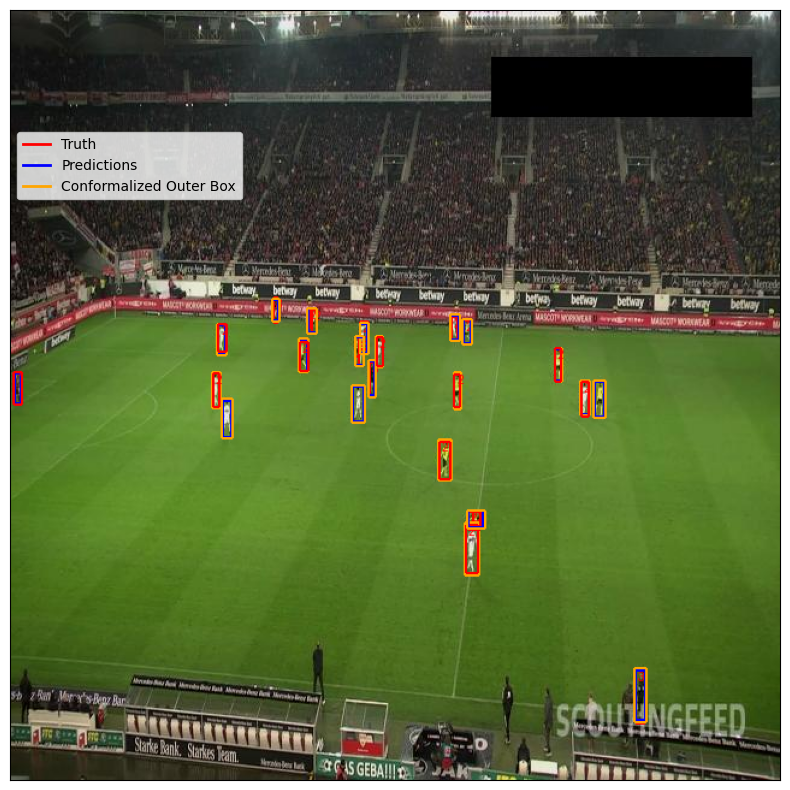

In [67]:
from deel.puncc.plotting import draw_bounding_box

for i in range(len(y_pred_new)):
    image_with_bbox = draw_bounding_box(
        image=image,
        box=bboxes_t[i],
        label=classes[i],
        legend="Truth",
        color="red",
    )
    image_with_bbox = draw_bounding_box(
        image=image,
        box=y_pred_new_t[i],
        legend="Predictions",
        color="blue",
    )
    image_with_bbox = draw_bounding_box(
        image=image,
        box=box_outer_t[i],
        legend="Conformalized Outer Box",
        color="orange",
    )
    
    # image_with_bbox = draw_bounding_box(
    #     image=image_with_bbox,
    #     box=box_inner[i],
    #     legend="Conformalized Inner Box",
    #     color="brown",
    # )

_ = draw_bounding_box(image=image, show=True)

In [ ]:
# Compute marginal coverage and average width of the prediction intervals
coverage = object_detection_mean_coverage(box_outer, bboxes)
average_area = object_detection_mean_area(box_outer)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average area: {np.round(average_area, 2)}")

**Inference on All Test Image**

In [ ]:
def infer_cp_on_test_set(X_val, y_val, labels_val, conformal_predictor, yolo_api):
    """
    Infer the conformal predictor on the test set.
    Args:
        X_val (np.ndarray): Test set image paths.
        y_val (np.ndarray): Test set ground truth boxes.
        labels_val (np.ndarray): Test set labels.
        conformal_predictor (deel.puncc.api.conformal_predictor.ConformalPredictor): Conformal predictor.
        yolo_api (odwrapper.YOLOAPIWrapper): YOLO API wrapper.
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Predictions, ground truth boxes, images, classes, inner boxes, outer boxes.
    """
    y_pred_val = []
    y_true_val = []
    images_val = []
    classes_val = []
    box_inner_val = []
    box_outer_val = []

    for i in range(len(X_val)):
        image_path, y_true, classes = X_val[i], y_val[i], labels_val[i]
        # Predict on the image
        y_new_api = yolo_api.predict_from_image(image_path)

        image = Image.open(image_path)

        # Choose the coverage target 1-alpha
        alpha = 0.3

        # Inference + UQ
        y_pred_new, box_inner, box_outer = conformal_predictor.predict(y_new_api, alpha=alpha)
        
        # Append the results
        #y_pred_new = tuple(map(tuple, y_pred_new))
        #y_true = tuple(map(tuple, y_true))
        #box_inner = tuple(map(tuple, box_inner))
        #box_outer= tuple(map(tuple, box_outer))

        y_pred_val.append(y_pred_new)
        y_true_val.append(y_true)
        images_val.append(image)
        classes_val.append(classes)
        box_inner_val.append(box_inner)
        box_outer_val.append(box_outer)

    return y_pred_val, y_true_val, images_val, classes_val, box_inner_val, box_outer_val

# we call the function to get the predictions and the UQ bounds
y_pred_val, y_true_val, images_val, classes_val, box_inner_val, box_outer_val = infer_cp_on_test_set(X_val, y_val, labels_val, conformal_predictor, yolo_api)

**Evaluation of our Conformal Predictor**

In [71]:
average_glo_area = []
for i in range(len(box_outer_val)):
    if(len(box_outer_val[i]) == 0):
       continue
    average_area = object_detection_mean_area(box_outer_val[i])
    average_glo_area.append(average_area)

print(f"Average area of prediction intervals: {np.mean(average_glo_area)}")
print(f"Average length of prediction intervals: {np.sqrt(np.mean(average_glo_area))}")

Average area of prediction intervals: 10793.853515625
Average length of prediction intervals: 103.89347076416016


In [72]:
cover = []
for i in range(len(y_pred_val)):
    if(box_outer_val[i].shape == y_true_val[i].shape):
        coverage = object_detection_mean_coverage(box_outer_val[i], y_true_val[i])
        coverage = np.round(coverage, 2)
        cover.append(coverage)
print(f"Marginal coverage: {np.mean(cover)}")

Marginal coverage: 0.5869776119402985
